# DCASE-2021 Audio-Video

Author: Maximo Cobos


In [ ]:
# Import necessary standard packages
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

#import tensorflow_addons as tfa

In [ ]:
tf.version.VERSION

'2.4.1'

## Input Data

Specify path to folder containing the video dataset and the output path for the tfrecords:

In [ ]:
# TFRecords folder
main_dir = '.\\tfrecords_gamma'
root_path = Path(main_dir)

# Train Fold
train_fold_path = '.\\dataset\\evaluation_setup\\fold1_train.csv'
traindf = pd.read_csv(train_fold_path, sep='\t', lineterminator='\r')
trainlist = traindf[traindf.columns[1]].tolist()
trainfiles = [Path(f).with_suffix('.tfrecords').name for f in trainlist]

#trainfiles = trainfiles[0:int(0.33*len(trainfiles))]

# Validation Fold
val_fold_path = '.\\dataset\\evaluation_setup\\fold1_test.csv'
valdf = pd.read_csv(val_fold_path, sep='\t', lineterminator='\r')
vallist = valdf[valdf.columns[1]].tolist()
valfiles = [Path(f).with_suffix('.tfrecords').name for f in vallist]

#valfiles = valfiles[0:int(0.33*len(valfiles))]

len(trainfiles), len(valfiles)

(8646, 3645)

Get class weights:

In [ ]:
def get_label(filepath):
    '''Receives a path to a video and returns its label
    '''
    scn_dict = {'airport': 0, 'shopping_mall': 1, 'metro_station': 2, 
                'street_pedestrian': 3, 'public_square': 4, 'street_traffic': 5,
                'tram': 6, 'bus': 7, 'metro': 8, 'park': 9}
    
    fileid = Path(filepath).name
    scn_id = fileid.split('-')[0]
    label = scn_dict[scn_id]
    return label

# Get labels
train_labels = [get_label(f) for f in trainfiles]
val_labels = [get_label(f) for f in valfiles]

trainfiles = [main_dir + '\\' + str(label) + '\\' + f for f,label in zip(trainfiles,train_labels)]
valfiles = [main_dir + '\\' + str(label) + '\\' + f for f,label in zip(valfiles,val_labels)]

N_val = len(valfiles)

# Get number of examples per class
num_class_ex = []
for i in range(10):
    num_class_ex.append(train_labels.count(i))     


# Get class weights    
N_train = len(train_labels)
num_classes = 10
class_weights = []
for i in range(num_classes):
    weight = ( 1 / num_class_ex[i]) * N_train / num_classes
    class_weights.append(weight)  

keylst = np.arange(0,len(class_weights))
class_weights = {keylst[i]: class_weights[i] for i in range(0, len(class_weights))}    

print("Class weights: ", class_weights)

Class weights:  {0: 1.240459110473458, 1: 1.0280618311533887, 2: 0.9681970884658455, 3: 0.8931818181818182, 4: 0.8804480651731159, 5: 0.877766497461929, 6: 1.1331585845347312, 7: 1.0727047146401985, 8: 1.2263829787234042, 9: 0.8594433399602386}


### Parsing function

In [ ]:
def parse_sequence(sequence_example, avmode = 'audiovideo'):
    """this function is the sequence parser for the created TFRecords file"""
    
    sequence_features = {'VideoFrames': tf.io.FixedLenSequenceFeature([], dtype=tf.string),                    
                         'Labels': tf.io.FixedLenSequenceFeature([], dtype=tf.int64)}

    context_features = {'AudioFrames': tf.io.FixedLenFeature((96000,), dtype=tf.float32),
                        'length': tf.io.FixedLenFeature([], dtype=tf.int64)}
    context, sequence = tf.io.parse_single_sequence_example(
    sequence_example, context_features=context_features, sequence_features=sequence_features)

    # get features context
    seq_length = tf.cast(context['length'], dtype = tf.int32)   

    # decode video and audio
    video = tf.io.decode_raw(sequence['VideoFrames'], tf.uint8)
    video = tf.reshape(video, shape=(seq_length, 224, 224, 3))
    audio = tf.cast(context['AudioFrames'], tf.float32)
    audio = tf.reshape(audio, shape=(64, 500, 3))
    label = tf.cast(sequence['Labels'], dtype = tf.int32)
        
    video = tf.cast(video, tf.float32)
    
    if avmode == 'audio':
        return audio, label
    elif avmode == 'video':
        return video, label
    elif avmode == 'audiovideo':
        return video, audio, label

Check parsing function:

In [ ]:
# Check parsing function
filesds = tf.data.Dataset.from_tensor_slices(trainfiles)
dataset = tf.data.TFRecordDataset(filesds)
dataset = dataset.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
datait = iter(dataset)
example = datait.get_next()
print(example[0].shape, example[1].shape, example[2].shape)

(50, 224, 224, 3) (64, 500, 3) (50,)


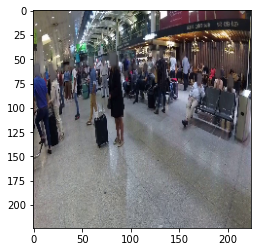

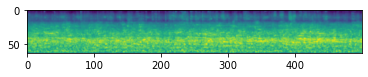

In [ ]:
plt.imshow(example[0][0,::].numpy().astype(np.uint8))
plt.show()
plt.imshow(example[1][:,:,0]);

## Augmentation

Mix-Up

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


def mix_up_audiovideo(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    imagesaudio_one, labels_one = ds_one
    imagesaudio_two, labels_two = ds_two
        
    images_one = imagesaudio_one[0]
    audios_one = imagesaudio_one[1]
    batch_size = tf.shape(images_one)[0]
    
    images_two = imagesaudio_two[0]
    audios_two = imagesaudio_two[1]   

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_laudio = tf.reshape(l, (batch_size, 1, 1, 1))
    x_lvideo = tf.reshape(l, (batch_size, 1, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_lvideo + images_two * (1 - x_lvideo)
    audios = audios_one * x_laudio + audios_two * (1 - x_laudio)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    
    images = tf.cast(images, tf.uint8)
    
    return (images, audios), labels

## Pipeline

### Audiovisual Modality
Useful functions for the pipeline

In [ ]:
def normalize_sp(sp):
    sp = sp - tf.math.reduce_min(sp) 
    sp = sp / tf.math.reduce_max(sp)
    sp = 2*(sp-0.5)
    return sp

def reshape_batch(data, labels):
    data_video = tf.reshape(data[0], shape=(-1,5,224,224,3))
    data_audio = tf.reshape(data[1], shape=(-1,64,50,3))
    data_labels = tf.reshape(labels, shape=(-1,10))
    return (data_video, data_audio), data_labels
    

(16, 5, 224, 224, 3) (16, 64, 50, 3)


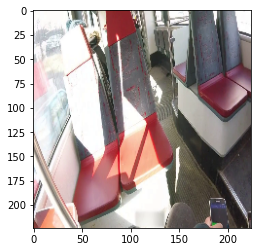

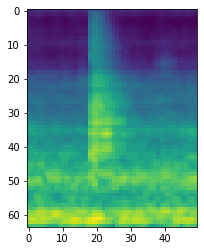

(10, 5, 224, 224, 3) (10, 64, 50, 3) (10, 10)


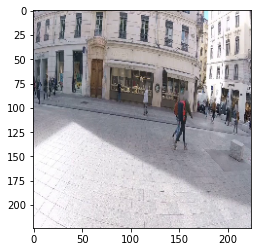

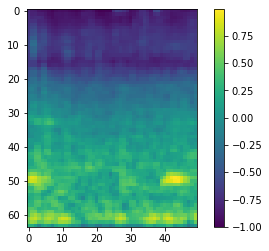

In [ ]:
def random_cut_gammavideo(video, audio, cut_length, audio_fs = 44100, audio_hop = 882, video_fps = 5):
    video_length = tf.shape(video)[0]
    audio_length = tf.shape(audio)[1]        
    # Generate random index for initial frame
    min_v = 0
    cut_length_frames = tf.cast(tf.math.round(cut_length*video_fps), dtype=tf.dtypes.int32)  
    max_v = video_length - cut_length_frames     
    rnum = tf.random.uniform([1], minval=min_v, maxval=max_v, dtype=tf.dtypes.int32)     
     # Cut video  
    video = video[rnum[0]:rnum[0]+cut_length_frames,...]    
    # Cut audio accordingly
    ini_frame = tf.math.round(tf.cast(rnum[0], dtype=tf.dtypes.float32)*(1/video_fps)*audio_fs*(1/audio_hop))
    end_frame = tf.math.round(ini_frame + cut_length*audio_fs/audio_hop)
    ini_frame = tf.cast(ini_frame, dtype=tf.dtypes.int32)
    end_frame = tf.cast(end_frame, dtype=tf.dtypes.int32)
    audio = audio[:,ini_frame:end_frame,:]
    return video, audio


def process_ds_audiovideo(video, audio, label, mode):
    
    # Cut randomly to 1 second
    if mode == 'train':
        video, audio = random_cut_gammavideo(video, audio, 1.0)
        audio = normalize_sp(audio)
        label = label[0]
        label = tf.one_hot(label,10)
    
    if mode == 'val':
        video = tf.reshape(video, shape=(10,5,224,224,3))
        audio = tf.transpose(audio,(1,0,2))
        audio = tf.reshape(audio, shape=(10,50,64,3))
        audio =tf.map_fn(fn=lambda t: normalize_sp(t) , elems=audio)
        audio = tf.transpose(audio,(0,2,1,3))
        label = label[0:10]
        label = tf.one_hot(label,10)
            
    
    return (video, audio), label


train_batch_size = 16
do_mixup = False

if do_mixup == True:

    train_ds_one = tf.data.Dataset.from_tensor_slices(trainfiles)
    train_ds_one = train_ds_one.shuffle(N_train)
    train_ds_one = train_ds_one.repeat()  

    train_ds_one = tf.data.TFRecordDataset(train_ds_one)
    train_ds_one = train_ds_one.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
    train_ds_one = train_ds_one.map(lambda video, audio, label: process_ds_audiovideo(video, audio, label, 'train'), num_parallel_calls=4)
    train_ds_one = train_ds_one.batch(train_batch_size)  

    train_ds_two = tf.data.Dataset.from_tensor_slices(trainfiles)
    train_ds_two = train_ds_two.shuffle(N_train)
    train_ds_two = train_ds_two.repeat()  

    train_ds_two = tf.data.TFRecordDataset(train_ds_two)
    train_ds_two = train_ds_two.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
    train_ds_two = train_ds_two.map(lambda video, audio, label: process_ds_audiovideo(video, audio, label, 'train'), num_parallel_calls=4)
    train_ds_two = train_ds_two.batch(train_batch_size) 

    trainds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
    trainds = trainds.map(
        lambda ds_one, ds_two: mix_up_audiovideo(ds_one, ds_two, alpha=0.3), num_parallel_calls=4
    )

else:    
    trainds = tf.data.Dataset.from_tensor_slices(trainfiles)
    trainds = trainds.shuffle(N_train)
    trainds = trainds.repeat()  

    trainds = tf.data.TFRecordDataset(trainds)
    trainds = trainds.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
    trainds = trainds.map(lambda video, audio, label: process_ds_audiovideo(video, audio, label, 'train'), num_parallel_calls=4)
    trainds = trainds.batch(train_batch_size)  




val_batch_size = 16

valds = tf.data.Dataset.from_tensor_slices(valfiles)
valds = tf.data.TFRecordDataset(valds)
valds = valds.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
valds = valds.map(lambda video, audio, label: process_ds_audiovideo(video, audio, label, 'val'), num_parallel_calls=4)
#valds = valds.batch(val_batch_size)  
#valds = valds.map(lambda data, labels: reshape_batch(data, labels), num_parallel_calls=4)


datait = iter(trainds)
example = datait.get_next()
print(example[0][0].shape, example[0][1].shape)
plt.imshow(example[0][0][0,0,:,:,:].numpy().astype(np.uint8))
plt.show()
plt.imshow(example[0][1][0,:,:,0]);
plt.show()

datait = iter(valds)
example = datait.get_next()
print(example[0][0].shape, example[0][1].shape, example[1].shape)
plt.imshow(example[0][0][0,0,:,:,:].numpy().astype(np.uint8))
plt.show()
plt.imshow(example[0][1][0,:,:,0]);
plt.colorbar()
plt.show()


## Audio Network

In [ ]:
from tensorflow.keras.layers import (Conv2D, Dense, Permute, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                    Reshape, BatchNormalization, ELU, Lambda, Input, MaxPooling2D, Activation,
                                    Dropout, add, multiply)
import tensorflow.keras.backend as k
from tensorflow.keras.models import Model
import tensorflow as tf
 
    
from tensorflow.keras.regularizers import l2
regularization = l2(0.0001)
 
def construct_asc_network_csse(include_classification=True, nclasses=10, **parameters):
    """
    Args:
        include_classification (bool): include classification layer
        **parameters (dict): setting use to construct the network presented in
        (https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9118879)
    """
    nfilters = parameters['nfilters']
    pooling = parameters['pooling']
    dropout = parameters['dropout']
    top_flatten = parameters['top_flatten']
    ratio = parameters['ratio']
    pre_act = parameters['pre_act']
    spectrogram_dim = parameters['spectrogram_dim']
    verbose = parameters['verbose']
 
    inp = Input(shape=spectrogram_dim)
 
    for i in range(0, len(nfilters)):
        if i == 0:
            x = conv_standard_post(inp, nfilters[i], ratio, pre_act=pre_act)
        else:
            x = conv_standard_post(x, nfilters[i], ratio, pre_act=pre_act)
 
        x = MaxPooling2D(pool_size=pooling[i])(x)
        x = Dropout(rate=dropout[i])(x)

    # Javier network
    if top_flatten == 'avg':
         x = GlobalAveragePooling2D()(x)
    elif top_flatten == 'max':
         x = GlobalMaxPooling2D()(x)      
 
    if include_classification:
        x = Dense(units=nclasses, activation='softmax', name='SP_Pred')(x)


    model = Model(inputs=inp, outputs=x)
 
    if verbose:
        print(model.summary())
 
    return model
 
 
def conv_standard_post(inp, nfilters, ratio, pre_act=False):
    """
    Block presented in (https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9118879)
    Args:
        inp (tensor): input to the block
        nfilters (int): number of filters of a specific block
        ratio (int): ratio used in the channel excitation
        pre_act (bool): presented in this work, use a pre-activation residual block
    Returns:
    """
    x1 = inp
 
    if pre_act:
 
        x = BatchNormalization()(inp)
        x = ELU()(x)
        x = Conv2D(nfilters, 3, padding='same')(x)
 
        x = BatchNormalization()(x)
        x = Conv2D(nfilters, 3, padding='same')(x)
 
    else:
 
        x = Conv2D(nfilters, 3, padding='same')(inp)
        x = BatchNormalization()(x)
        x = ELU()(x)

        x = Conv2D(nfilters, 3, padding='same')(x)
        x = BatchNormalization()(x)
 
    # shortcut
    x1 = Conv2D(nfilters, 1, padding='same')(x1)
    x1 = BatchNormalization()(x1)
 
    x = module_addition(x, x1)
 
    x = ELU()(x)
    
    x = channel_spatial_squeeze_excite(x, ratio=ratio)
 
    x = module_addition(x, x1)
 
    return x
 
 
def channel_spatial_squeeze_excite(input_tensor, ratio=16):
    """ Create a spatial squeeze-excite block
    Args:
        input_tensor: input Keras tensor
        ratio: number of output filters
    Returns: a Keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    -   [Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks]
        (https://arxiv.org/abs/1803.02579)
    """
 
    cse = squeeze_excite_block(input_tensor, ratio)
    sse = spatial_squeeze_excite_block(input_tensor)
 
    x = add([cse, sse])
    return x
 
 
def squeeze_excite_block(input_tensor, ratio=16):
    """ Create a channel-wise squeeze-excite block
    Args:
        input_tensor: input Keras tensor
        ratio: number of output filters
    Returns: a Keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    """
 
    init = input_tensor
    channel_axis = 1 if k.image_data_format() == "channels_first" else -1
    filters = _tensor_shape(init)[channel_axis]
    se_shape = (1, 1, filters)
 
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
 
    if k.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)
 
    x = multiply([init, se])
    return x
 
 
def spatial_squeeze_excite_block(input_tensor):
    """ Create a spatial squeeze-excite block
    Args:
        input_tensor (): input Keras tensor
    Returns: a Keras tensor
    References
    -   [Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks]
        (https://arxiv.org/abs/1803.02579)
    """
 
    se = Conv2D(1, (1, 1), activation='sigmoid', use_bias=False,
                kernel_initializer='he_normal')(input_tensor)
 
    x = multiply([input_tensor, se])
    return x
 
 
def module_addition(inp1, inp2):
    """
    Module of addition of two tensors with same H and W, but can have different channels
    If number of channels of the second tensor is the half of the other, this dimension is repeated
    Args:
        inp1 (tensor): one branch of the addition module
        inp2 (tensor): other branch of the addition module
    Returns:
    """
    if k.int_shape(inp1)[3] != k.int_shape(inp2)[3]:
        x = add(
            [inp1, Lambda(lambda y: k.repeat_elements(y, rep=int(k.int_shape(inp1)[3] // k.int_shape(inp2)[3]),
                                                      axis=3))(inp2)])
    else:
        x = add([inp1, inp2])
 
    return x
 
 
def _tensor_shape(tensor):
    """
    Obtain shape in order to use channel excitation
    Args:
        tensor (tensor): input tensor
    Returns:
    """
    return tensor.get_shape()

audio_network_settings = {
    'nfilters': (32, 64, 128),
    #'pooling': [(2, 1), (2, 1), (2, 1)],
    'pooling': [(1, 2), (1, 2), (1, 1)],
    'dropout': [0.0, 0.0, 0.0],
    'top_flatten': 'avg',
    'ratio': 2,
    'pre_act': False,
    'spectrogram_dim': (64, 50, 3),
    'verbose': True
}

audio_model = construct_asc_network_csse(include_classification=True, **audio_network_settings)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 50, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 50, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
elu (ELU)                       (None, 64, 50, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Load weights
pretrained_audio_path = 'BEST_AUDIO_MODEL'
audio_model.load_weights(pretrained_audio_path)

## Video Network

In [ ]:
from tensorflow.keras.layers import TimeDistributed, GRU, Activation, GlobalAveragePooling1D, Bidirectional

regularization = l2(0.001)    

num_classes = 10 
input_shape = (5,224,224,3)
input_vid = Input(shape = input_shape)

# Block 1
x = TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block1_conv1')(input_vid)

x = TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block1_conv2')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block1_pool")(x)

# Block 2
x = TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block2_conv1')(x)

x = TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block2_conv2')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block2_pool")(x)

# Block 3
x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block3_conv1')(x)

x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block3_conv2')(x)

x = TimeDistributed(Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block3_conv3')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block3_pool")(x)

# Block 4
x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block4_conv1')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block4_conv2')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block4_conv3')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block4_pool")(x)

# Block 5
x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block5_conv1')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block5_conv2')(x)

x = TimeDistributed(Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
           kernel_regularizer=l2(0.0002),
           activation='relu'), name='block5_conv3')(x)

x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), name="block5_pool")(x)


x = TimeDistributed(GlobalMaxPooling2D(), name='TD_C_GlobAvPooling2D')(x)

# Recurrent Block
fw = GRU(32, return_sequences=True, stateful=False, recurrent_dropout = 0.0, name='VID_RNN_fw')
bw = GRU(32, return_sequences=True, stateful=False, recurrent_dropout = 0.0, go_backwards=True, name='VID_RNN_bw')
x = Bidirectional(fw, backward_layer=bw, name='VID_RNN_bidir')(x) 
x = Dropout(0.5, name='VID_C2_Dropout')(x) #0.35
x = Dense(num_classes, kernel_regularizer = regularization, name ='VID_C2_Dense')(x)
x = Activation('softmax', name = 'VID_C2_Act_softmax_1')(x)
x = GlobalAveragePooling1D(name='VID_Pred')(x)
          
video_model = Model(inputs=input_vid, outputs=x)  
video_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 224, 224, 3)]  0         
_________________________________________________________________
block1_conv1 (TimeDistribute (None, 5, 224, 224, 64)   1792      
_________________________________________________________________
block1_conv2 (TimeDistribute (None, 5, 224, 224, 64)   36928     
_________________________________________________________________
block1_pool (TimeDistributed (None, 5, 112, 112, 64)   0         
_________________________________________________________________
block2_conv1 (TimeDistribute (None, 5, 112, 112, 128)  73856     
_________________________________________________________________
block2_conv2 (TimeDistribute (None, 5, 112, 112, 128)  147584    
_________________________________________________________________
block2_pool (TimeDistributed (None, 5, 56, 56, 128)    0   

In [ ]:
# load weights
pretrained_video_path = 'BEST_VIDEO_MODEL'
video_model.load_weights(pretrained_video_path)

## Join Sub-Networks (RNN)

In [ ]:
audio_sub_input = audio_model.input

audioout = audio_model.layers[-1].output
x = audio_model.layers[-3].output
x = tf.keras.layers.Permute((2,1,3))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(x)
audio_sub_output = tf.keras.layers.AveragePooling1D(3,2)(x)
audio_subnetwork = Model(inputs=audio_sub_input, outputs=audioout)

# Freeze all layers
for layer in audio_subnetwork.layers:
    print('Setting layer {} non-trainable'.format(layer.name))
    layer.trainable = False
audio_subnetwork.summary()

Setting layer input_1 non-trainable
Setting layer conv2d non-trainable
Setting layer batch_normalization non-trainable
Setting layer elu non-trainable
Setting layer conv2d_1 non-trainable
Setting layer conv2d_2 non-trainable
Setting layer batch_normalization_1 non-trainable
Setting layer batch_normalization_2 non-trainable
Setting layer add non-trainable
Setting layer elu_1 non-trainable
Setting layer global_average_pooling2d non-trainable
Setting layer reshape non-trainable
Setting layer dense non-trainable
Setting layer dense_1 non-trainable
Setting layer conv2d_3 non-trainable
Setting layer multiply non-trainable
Setting layer multiply_1 non-trainable
Setting layer add_1 non-trainable
Setting layer add_2 non-trainable
Setting layer max_pooling2d non-trainable
Setting layer dropout non-trainable
Setting layer conv2d_4 non-trainable
Setting layer batch_normalization_3 non-trainable
Setting layer elu_2 non-trainable
Setting layer conv2d_5 non-trainable
Setting layer conv2d_6 non-traina

In [ ]:
video_sub_input = video_model.input

videoout = video_model.layers[-1].output
video_sub_output = video_model.layers[-6].output
video_subnetwork = Model(inputs=video_sub_input, outputs=videoout)

# Freeze all layers
for layer in video_subnetwork.layers:
    print('Setting layer {} non-trainable'.format(layer.name))
    layer.trainable = False
video_subnetwork.summary()

Setting layer input_2 non-trainable
Setting layer block1_conv1 non-trainable
Setting layer block1_conv2 non-trainable
Setting layer block1_pool non-trainable
Setting layer block2_conv1 non-trainable
Setting layer block2_conv2 non-trainable
Setting layer block2_pool non-trainable
Setting layer block3_conv1 non-trainable
Setting layer block3_conv2 non-trainable
Setting layer block3_conv3 non-trainable
Setting layer block3_pool non-trainable
Setting layer block4_conv1 non-trainable
Setting layer block4_conv2 non-trainable
Setting layer block4_conv3 non-trainable
Setting layer block4_pool non-trainable
Setting layer block5_conv1 non-trainable
Setting layer block5_conv2 non-trainable
Setting layer block5_conv3 non-trainable
Setting layer block5_pool non-trainable
Setting layer TD_C_GlobAvPooling2D non-trainable
Setting layer VID_RNN_bidir non-trainable
Setting layer VID_C2_Dropout non-trainable
Setting layer VID_C2_Dense non-trainable
Setting layer VID_C2_Act_softmax_1 non-trainable
Setting

In [ ]:
from tensorflow.keras.layers import concatenate

x = concatenate([audio_sub_output, video_sub_output])
fw = tf.keras.layers.GRU(64,return_sequences=True, stateful=False, dropout = 0.0, name='RNN_fw')
bw = tf.keras.layers.GRU(64,return_sequences=True, stateful=False, dropout = 0.0, go_backwards= True, name='RNN_bw')
x = tf.keras.layers.Bidirectional(fw, backward_layer=bw, name='RNN_bidir')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(num_classes, activation='softmax')(x)
x = concatenate([x, audioout, videoout])
x = Dense(num_classes, name ='MULTI_C2_Dense2')(x)
x = Activation('softmax', name='MULTI_Pred')(x)

multi_model = Model(inputs=[video_sub_input, audio_sub_input], outputs=x)
multi_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 50, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 50, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
elu (ELU)                       (None, 64, 50, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Compile and train

In [ ]:
# learning_rate = 0.001
# weight_decay = 0.0001
# opt = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

learning_rate = 0.0001 
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

multi_model.compile(
    loss = {'MULTI_Pred': 'categorical_crossentropy'},
    optimizer=opt,            
    metrics = {'MULTI_Pred': 'accuracy'},
)      

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
callbacks = []
ckpt_dir = 'PATH_TO_STORE\checkpoints_multi'
model_name = 'multi_final'
callbacks.append(
            ModelCheckpoint(
                filepath=os.path.join(ckpt_dir, '%s-{epoch:02d}-{val_accuracy:.2f}.hdf5' % model_name),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                save_weights_only=True,
                verbose=True,
            )
        )

callbacks.append(
                EarlyStopping(
                    monitor="val_loss",
                    patience=80,
                )
            )

callbacks.append(
                ReduceLROnPlateau(
                    monitor="val_loss", 
                    factor=0.5, 
                    patience=15, 
                    verbose=True,
                )
            )

callbacks.append(
    CSVLogger(                    
        filename = os.path.join(ckpt_dir, '%s.csv' % model_name),
        append = False,                
    )
)

In [ ]:
# Train model
history = multi_model.fit(
            trainds,
            epochs=200,
            steps_per_epoch= int(N_train/train_batch_size),    # Set according to number of examples and training batch size
            validation_data = valds,
            #validation_steps = int(N_val/val_batch_size),
            validation_steps = int(N_val),
            callbacks=callbacks,  # Include list of callbacks    
            #class_weight = class_weights,    
        )

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### Final Fine-Tuning

In [ ]:
multi_model.load_weights('BEST_AUDIOVISUAL_MODEL')

# Un-Freeze all layers
for layer in multi_model.layers:
    print('Setting layer {} trainable'.format(layer.name))
    layer.trainable = True
multi_model.summary()


learning_rate = 0.000001
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)

multi_model.compile(
    loss = {'MULTI_Pred': 'categorical_crossentropy'},
    optimizer=opt,            
    metrics = {'MULTI_Pred': 'accuracy'},
)      

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
callbacks = []
ckpt_dir = 'PATH_TO_STORE\checkpoints_multi'
model_name = 'multi_finalun_2'
callbacks.append(
            ModelCheckpoint(
                filepath=os.path.join(ckpt_dir, '%s-{epoch:02d}-{val_accuracy:.2f}.hdf5' % model_name),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                save_weights_only=True,
                verbose=True,
            )
        )

callbacks.append(
                EarlyStopping(
                    monitor="val_loss",
                    patience=80,
                )
            )

callbacks.append(
                ReduceLROnPlateau(
                    monitor="val_loss", 
                    factor=0.5, 
                    patience=15, 
                    verbose=True,
                )
            )

callbacks.append(
    CSVLogger(                    
        filename = os.path.join(ckpt_dir, '%s.csv' % model_name),
        append = False,                
    )
)


# Train model
history = multi_model.fit(
            trainds,
            epochs=200,
            steps_per_epoch= int(N_train/train_batch_size),    # Set according to number of examples and training batch size
            validation_data = valds,
            #validation_steps = int(N_val/val_batch_size),
            validation_steps = int(N_val),
            callbacks=callbacks,  # Include list of callbacks    
            #class_weight = class_weights,    
        )

## Evaluate Model

In [ ]:
def process_ds_eval(video, audio, label):

    video = tf.reshape(video, shape=(10,5,224,224,3))
    audio = tf.transpose(audio,(1,0,2))
    audio = tf.reshape(audio, shape=(10,50,64,3))
    audio =tf.map_fn(fn=lambda t: normalize_sp(t) , elems=audio)
    audio = tf.transpose(audio,(0,2,1,3))
    label = label[0:10]
    label = tf.one_hot(label,10)

    return (video, audio), label


evalds = tf.data.Dataset.from_tensor_slices(valfiles)
evalds = tf.data.TFRecordDataset(evalds)
evalds = evalds.map(lambda tf_file: parse_sequence(tf_file,'audiovideo'), num_parallel_calls=4)
evalds = evalds.map(lambda video, audio, label: process_ds_eval(video, audio, label), num_parallel_calls=4)

# it = iter(evalds)
# ex = it.get_next()
# ex[0][0].shape

In [ ]:
multi_model.load_weights('FINAL_BEST_AUDIOVISUAL')
multi_model.evaluate(evalds)